# imports

In [1]:
import base64
import io
import json

import boto3
from botocore.exceptions import ClientError
from IPython.display import display
from PIL import Image

brt = boto3.client("bedrock-runtime")

# constants

In [2]:
DISCUSSION_PROMPT = "Where are these fish found?"
FORM_PHYSICAL_BUILD = "tall"
FORM_APPEARANCE = "pale, blue eyed, with blonde hair"
FORM_UNIQUE_FEATURES = "freckles"
GUARDRAIL_ARN = "arn:aws:bedrock:us-east-1:867344447984:guardrail/gfnf9qp6lds2"
GUARDRAIL_VERSION = "1"
MAX_TOKENS = 100

# fish match

In [3]:
text_prompt = f"""Based on these physical characteristics:

- Build: {FORM_PHYSICAL_BUILD}
- Appearance: {FORM_APPEARANCE}
- Unique features: {FORM_UNIQUE_FEATURES}

Match this person to a species of fish. Provide a creative and detailed explanation why this fish matches their features. Include both scientific name and common name. Be specific and playful in your comparison.

Create this comparison in five sentences or less."""
messages = [
    {
        "role": "user",
        "content": [{"text": text_prompt}],
    }
]
fish_match = ""

try:
    response = brt.converse(
        guardrailConfig={
            "guardrailIdentifier": GUARDRAIL_ARN,
            "guardrailVersion": GUARDRAIL_VERSION,
        },
        inferenceConfig={"maxTokens": MAX_TOKENS},
        modelId="amazon.titan-text-express-v1",
        messages=messages,
    )
    fish_match = response["output"]["message"]["content"][0]["text"]
    messages.append(response["output"]["message"])  # FOR USE LATER IN FISH DISCUSSION

except (ClientError, Exception) as e:
    print(f"ERROR: Can't invoke. Reason: {e}")
    exit(1)

print(fish_match)


Based on the provided physical characteristics, this person is best matched with the Bluegill fish. The Bluegill fish has a tall and slender build, pale skin, blue eyes, and blonde hair with freckles. The Bluegill fish is also known for its unique bluegill markings on its fins and body, which resemble freckles. Additionally, Bluegill fish are native to North America, where the person is likely from, and are commonly found in freshwater lakes and ponds, which align


# fish visualization

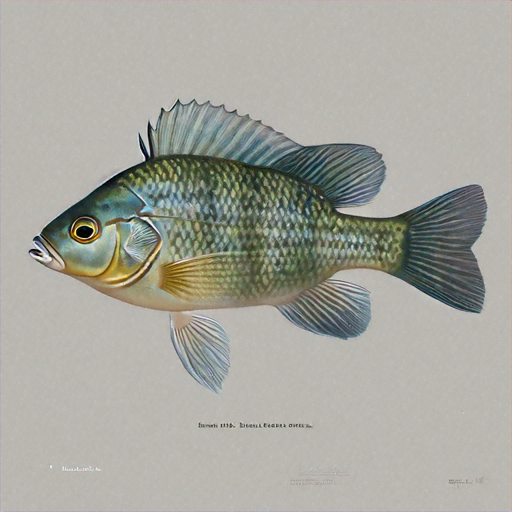

In [6]:
class ImageError(Exception):
    def __init__(self, message):
        self.message = message


image_prompt = f"""A beautiful, detailed, scientific illustration of the fish species mentioned
below swimming in its natural habitat, showing its distinctive features clearly.
{fish_match}"""

body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {"text": image_prompt[:512]},
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "height": 512,
            "width": 512,
            "cfgScale": 8.0,
            "seed": 0,
        },
    }
)

try:
    response = brt.invoke_model(
        body=body,
        modelId="amazon.titan-image-generator-v1",
        accept="application/json",
        contentType="application/json",
    )
    response_body = json.loads(response.get("body").read())
    base64_image = response_body.get("images")[0]
    base64_bytes = base64_image.encode("ascii")
    image_bytes = base64.b64decode(base64_bytes)
    finish_reason = response_body.get("error")

    if finish_reason is not None:
        raise ImageError(f"Image generation error. Error is {finish_reason}")
    image = Image.open(io.BytesIO(image_bytes))
    display(image)

except ClientError as err:
    message = err.response["Error"]["Message"]
    print("A client error occured: " + format(message))
except ImageError as err:
    print(err.message)

# fish discussion

In [5]:
messages.append(
    {
        "role": "user",
        "content": [{"text": DISCUSSION_PROMPT}],
    }
)

try:
    response = brt.converse(
        modelId="amazon.titan-text-express-v1",
        messages=messages,
    )

    fish_discussion = response["output"]["message"]["content"][0]["text"]

except (ClientError, Exception) as e:
    print(f"ERROR: Can't invoke. Reason: {e}")
    exit(1)

print(fish_discussion)

The Bluegill fish is native to North America, where the person is likely from, and is commonly found in freshwater lakes and ponds.
